# Modèles de distributions d'espèces - Cas des forets urbaines à Montreal

## 1 - Introduction 
Le but de ce projet est de trouver un moyen de prédire efficacement la distribution des différentes espèces d'arbres à travers la région de Montreal, ce qui permetterait aux aménagistes forestiers de s'assurer que les espèces plantées survivent au changement climatique de la région. Ce projet se concentre particulièrement sur les **forets urbaines**.

Il sera alors question dans ce notebook de fournir le code capable de créer un **modèle de distribution d'espèces (SDM)** en utilisant des algorithmes **d'apprentissage automatique (Machine Learning)** avec le langage **R**.

## 2 - Collecte et traitement des données 
Pour créer un modèle de distribution d'espèces, on aura besoin de deux types de données : 
* **Les données d'occurrence :** Ces données relatent l'observation d'une espèce à une localisation (et/ou une date) précise. Ces données peuvent décrire le nombre d'une espèce dans chaque zone, on parlera alors de données *d'abondance*, sinon elles peuvent aussi seulement décrire la *présence et l'absence confirmée* d'une espèce dans la zone. Généralement, même les données contenant des absences confirmées sont rares car elles sont difficiles à produire. Nous trouverons alors plutôt des données *de présence seulement (presence-only data)*, et c'est cela que l'on va utiliser dans ce projet.


* **Les données environnementales :** Ces données relatent le climat d'une région donnée en le décrivant avec plusieurs variables environnementales (température annuelle minimale, précipitation maximale par saison...etc.). Ces données séparent généralement la région en plusieurs cellules à la manière d'une grille où chaque cellule contient des valeurs environnementales différentes. 

### 2.1 - Données d'occurrence :
Les données d'occurrence utilisées ici seront les données d'arbres publics à Montreal (voir ce lien : https://donnees.montreal.ca/ville-de-montreal/arbres (Consulté le 03/04/2021)). 

In [1]:
# Décommenter cette ligne pour installer le package BlockCV (introuvable sur Anaconda)
# install.packages('blockCV')

In [2]:
# Importer les bibliothèques nécessaires 

# Tidyverse : une bibliothèque populaire de manipulation de données
# Elle contient plusieurs autres packages telles que dplyr, readr, ggplot...etc.
library('tidyverse')

# Sp : Fournit des classes et des méthodes permettant de représenter et manipuler les données géospatiales
library('sp')

# Raster : Api haut niveau permettant la lecture / la manipulation des données raster et vecteurs
library('raster')

# RandomForest : Permet la création d'un modèle Random Forest
library('randomForest')

# RGDAL : Implementation Haut niveau de la bibliothèque publique GDAL
library('rgdal')

# Caret : Bibliothèque d'évalation des modèles de Machine Learning
library('caret')

# Conflicted : Affiche les conflits entre les packages si il y en a (lors de l'appel d'une fonction par exemple)
library('conflicted')

# Rgeos : Est utilisée ici pour créer des polygones utiles à la génération de données de pseudo-absence
library('rgeos')

# BlockCV : Permet la séparation des données de test/entrainement en utilsant la Block Cross Validation
library('blockCV')

# Dismo : Bibliothèque très populaire permettant d'implémenter des fonctions et des modèles associés aux SDMs
library('dismo')

# ROCR : Bibliothèque de génération des courbes ROC
library('ROCR')

# Corrplot : Afficher les matrices de corrélation
library('corrplot')

# Options de visualisation de dataframes : limiter le nombre de lignes et afficher un maximum de colonnes
options(repr.matrix.max.cols=50, repr.matrix.max.rows=20)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Attaching package: 'raster'

The following object is masked from 'package:dplyr':

    select

The following object is masked from 'package:tidyr':

    extract

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:dplyr':

    combine

The following object is mas

In [3]:
# Lecture du fichier CSV
occurrence_data_raw <- read_csv('./data/arbres-publics.csv')

# Affichage du résultat
summary(occurrence_data_raw)

Parsed with column specification:
cols(
  .default = col_character(),
  EMP_NO = col_double(),
  ARROND = col_double(),
  Rue = col_logical(),
  COTE = col_logical(),
  No_civique = col_logical(),
  Coord_X = col_double(),
  Coord_Y = col_double(),
  DHP = col_double(),
  Date_releve = col_datetime(format = ""),
  Date_plantation = col_datetime(format = ""),
  LOCALISATION = col_logical(),
  Longitude = col_double(),
  Latitude = col_double()
)
See spec(...) for full column specifications.
Warning message:
"819326 parsing failures.
  row          col           expected                                           actual                        file
99669 Rue          1/0/T/F/TRUE/FALSE Avenue AdhÃ©mar-Mailhiot                         './data/arbres-publics.csv'
99669 COTE         1/0/T/F/TRUE/FALSE E                                                './data/arbres-publics.csv'
99669 No_civique   1/0/T/F/TRUE/FALSE 12323                                            './data/arbres-publics.csv'
99

   INV_TYPE             EMP_NO           ARROND       ARROND_NOM       
 Length:318077      Min.   :     2   Min.   : 1.00   Length:318077     
 Class :character   1st Qu.: 52512   1st Qu.: 3.00   Class :character  
 Mode  :character   Median :102232   Median : 7.00   Mode  :character  
                    Mean   :119664   Mean   : 8.89                     
                    3rd Qu.:179657   3rd Qu.:12.00                     
                    Max.   :447625   Max.   :33.00                     
                                                                       
   Rue            COTE         No_civique      Emplacement       
 Mode:logical   Mode:logical   Mode :logical   Length:318077     
 NA's:318077    NA's:318077    FALSE:6876      Class :character  
                               TRUE :95        Mode  :character  
                               NA's :311106                      
                                                                 
                            

Nous ne voulons garder que les informations les plus importantes. Ici ces informations sont l'espèce (le nom latin car il est plus précis), la Latitude, la Longitude et la valeur cible (la classe).

On crée la classe nous-mêmes. Ici la classe sera l'attribut "present" qui représente la présence d'une espèce. Elle sera initialisée à 1 pour tous les enregistrements.

In [27]:
# Création de la classe 
occurrence_data_raw$Present <- 1

# Selection des attributs pertinents
occurrence_data <- occurrence_data_raw %>% dplyr::select('Essence_latin', 'Latitude', 'Longitude', 'Present')
occurrence_data$Essence_latin <- as.factor(occurrence_data$Essence_latin)

In [22]:
occurrence_data

Essence_latin,Latitude,Longitude,Present
Gleditsia triacanthos 'Skyline',45.53515,-73.71551,1
Gleditsia triacanthos 'Skyline',45.53522,-73.71559,1
Gymnocladus dioicus,45.53511,-73.71566,1
Fraxinus nigra 'Fall Gold',45.53562,-73.71530,1
Quercus rubra,45.53560,-73.71560,1
Quercus macrocarpa,45.53582,-73.71571,1
Acer saccharinum 'Montréal',45.53582,-73.71536,1
Acer platanoides 'Emerald Queen',45.53619,-73.71556,1
Thuja occidentalis 'Nigra',45.53635,-73.71555,1
Thuja occidentalis 'Nigra',45.53628,-73.71552,1


Il est maintenant temps de nettoyer nos données. 

Premièrement, on recherche les enregistrements avec des valeurs manquantes (dans les attributs pertinents) et on les enlève.
Puis on enlève les doublons dans les données si il y en a.

In [32]:
# Statistiques complètes sur le dataset
summary(occurrence_data)

# Nombre total d'espèces dans le dataset
print(paste("Nombre d'espèces : ", length(levels(occurrence_data$Essence_latin))))

# Nombre total d'espèces dans le dataset dépassant le seuil
threshold <- 10
oc_data_trimmed = occurrence_data %>%
      group_by(Essence_latin) %>%
      dplyr::filter(n() > threshold)
count_species <- length(levels(droplevels(oc_data_trimmed$Essence_latin)))
print(paste("Nombre d'espèces dépassant", threshold, "elements : ", count_species))

                         Essence_latin       Latitude          Longitude     
 Acer saccharinum               : 33168   Min.   : 0.04566   Min.   :-77.36  
 Acer platanoides               : 31516   1st Qu.:45.48524   1st Qu.:-73.64  
 Fraxinus pennsylvanica         : 23093   Median :45.53187   Median :-73.60  
 Tilia cordata                  : 15793   Mean   :45.50730   Mean   :-73.61  
 Celtis occidentalis            :  9455   3rd Qu.:45.56468   3rd Qu.:-73.57  
 Gleditsia triacanthos 'Skyline':  9377   Max.   :72.35156   Max.   :-24.29  
 (Other)                        :195675   NA's   :4          NA's   :4       
    Present 
 Min.   :1  
 1st Qu.:1  
 Median :1  
 Mean   :1  
 3rd Qu.:1  
 Max.   :1  
            

[1] "Nombre d'espèces :  680"
[1] "Nombre d'espèces dépassant 10 elements :  420"


In [33]:
# ===== 1. Valeurs manquantes =======
before_count <- sum(count(occurrence_data)$n)
occurrence_data <- occurrence_data %>% dplyr::filter((!is.na(Longitude) | Longitude == 0) & 
                                                     !is.na(Latitude) & !is.na(Essence_latin))
after_count <- sum(count(occurrence_data)$n)

# Afficher le nombre de lignes supprimées
sprintf("Nombre de lignes avec valeurs manquantes enlevées : %d", before_count - after_count)

# ===== 2. Enregistrements doublons =======
before_count <- sum(count(occurrence_data)$n)
occurrence_data <- occurrence_data %>% dplyr::distinct()
after_count <- sum(count(occurrence_data)$n)

# Afficher le nombre de lignes supprimées
sprintf("Nombre de lignes doublons enlevées : %d", before_count - after_count)

# ===== 3. Espèces pas assez représentées ======
threshold <- 10
before_count <- length(levels(occurrence_data$Essence_latin))
occurrence_data = occurrence_data %>%
      group_by(Essence_latin) %>%
      dplyr::filter(n() > threshold)
after_count <- length(levels(droplevels(occurrence_data$Essence_latin)))

# Afficher le nombre d'espèces enlevées
sprintf("Nombre d'especes enlevées : %d", before_count - after_count)

[1] "Nombre de lignes avec valeurs manquantes enlevées : 4"

[1] "Nombre de lignes doublons enlevées : 1587"

[1] "Nombre d'especes enlevées : 260"

Il est important à noter que cette base de données contient des enregistrements de plusieurs espèces différentes et les modèles de distribution d'espèces sont utilisées pour modéliser une espèce étudiée à la fois. Nous devons donc séparer les enregistrements par espèces.

Pour illustrer plus facilement le processus, on ne va travailler dans ce notebook qu'avec une espèce, celle qui est la plus présente dans les données.

In [36]:
# Identifier et tirer l'espèce la plus présente dans les données d'occurrence
species_counts <- occurrence_data %>% count(Essence_latin, sort=TRUE)
most_found_species <- species_counts$Essence_latin[1]
species_data <- occurrence_data %>% dplyr::filter(Essence_latin==most_found_species) %>% ungroup()
species_data 

Essence_latin,Latitude,Longitude,Present
Acer saccharinum,45.54076,-73.69629,1
Acer saccharinum,45.54860,-73.65310,1
Acer saccharinum,45.54869,-73.65331,1
Acer saccharinum,45.54880,-73.65326,1
Acer saccharinum,45.53700,-73.71862,1
Acer saccharinum,45.53703,-73.71842,1
Acer saccharinum,45.52495,-73.71480,1
Acer saccharinum,45.54861,-73.63966,1
Acer saccharinum,45.55094,-73.63016,1
Acer saccharinum,45.57792,-73.64505,1


In [37]:
# Enlever le nom de l'espèce de la dataframe
species_data <- species_data %>% dplyr::select('Longitude', 'Latitude', 'Present')

In [38]:
species_data

Longitude,Latitude,Present
-73.69629,45.54076,1
-73.65310,45.54860,1
-73.65331,45.54869,1
-73.65326,45.54880,1
-73.71862,45.53700,1
-73.71842,45.53703,1
-73.71480,45.52495,1
-73.63966,45.54861,1
-73.63016,45.55094,1
-73.64505,45.57792,1


Affichons ces données sur une carte, pour cela nous allons utiliser la fonction plot (dont le comportement change grâce à la bibliothèque "sf").

Nous allons avoir besoin aussi d'une carte du monde sur laquelle dessiner les points. Nous utilisons ici une carte de la ressource publique *Natural Earth* (ref : https://www.naturalearthdata.com/ (consulté le 06/04/2021)).

In [39]:
# Carte du monde avec les bordures des villes / provinces dans chaque pays 
world_map <- shapefile("data/natural_earth_vector/10m_cultural/ne_10m_admin_1_states_provinces.shp")

In [40]:
# Créer une fonction pour dessiner les points d'occurrence sur la carte du monde
plot_species_data_on_map <- function(species_data, background_map=world_map, plot_label="", 
                                     col="dark green", pch=20, cex=0.1, extent=NULL, ...){
    # Calculer l'extent si il est NULL
    # Ici l'extent est le "carré" entourant tous les points de notre dataset (minlong, maxlong, minlat, maxlat)
    if (is.null(extent)){
        # Si les données sont sous forme de SpatialPoints, 
        # utiliser la fonction extent pour extraire l'extent, sinon le calculer manuellement
        if (class(species_data) == 'SpatialPoints'){
            extent <- extent(species_data)
        } else{
            extent <- c(min(species_data$Longitude), max(species_data$Longitude), 
                min(species_data$Latitude), max(species_data$Latitude))
        }
    }
    
    # Reprojeter les données d'occurrence
    if (!is.na(crs(species_data))){
        species_data <- spTransform(species_data, crs(background_map))
    }
        
    # Afficher la carte background
    plot(background_map, xlim=c(extent[1], extent[2]), 
         ylim=c(extent[3], extent[4]), col="light gray", 
           xlab="longitude", ylab="latitude", main=plot_label)
    
    # Dessiner les points sur la carte
    if (class(species_data) == 'SpatialPoints'){
        points(species_data, col=col, pch=pch, cex=cex)
    } else {
        points(species_data$Longitude, species_data$Latitude, col=col, pch=pch, cex=cex)
    }
    
    box()
}

Warning message in if (class(species_data) == "SpatialPoints") {:
"la condition a une longueur > 1 et seul le premier élément est utilisé"Warning message in if (class(x) == "character") {:
"la condition a une longueur > 1 et seul le premier élément est utilisé"Warning message in if (class(x) != "CRS") {:
"la condition a une longueur > 1 et seul le premier élément est utilisé"Warning message in if (class(species_data) == "SpatialPoints") {:
"la condition a une longueur > 1 et seul le premier élément est utilisé"

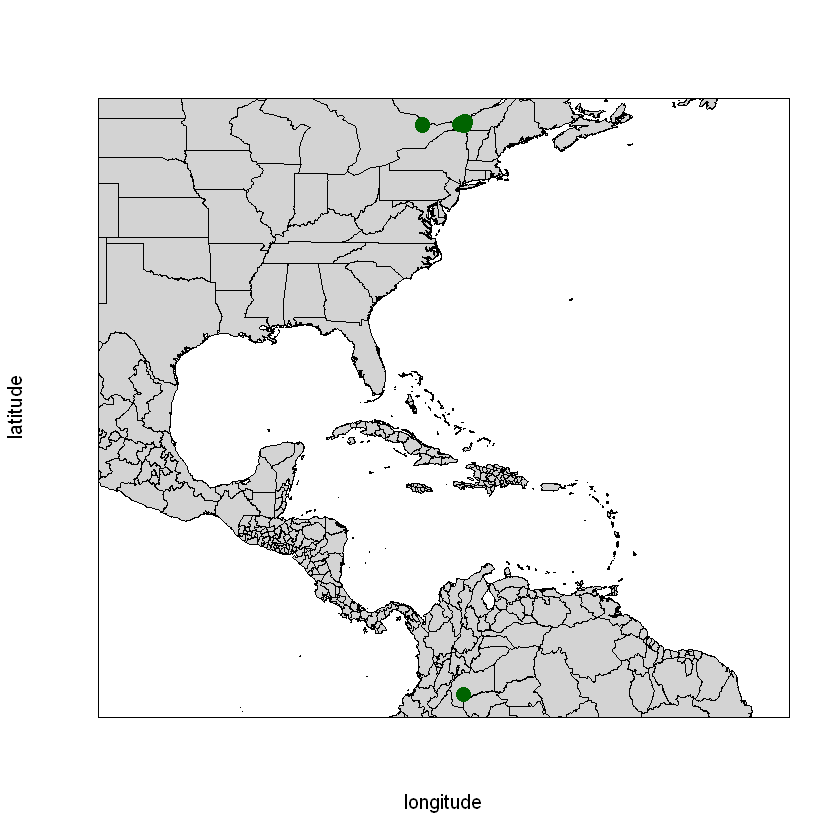

In [41]:
# Afficher la carte
plot_species_data_on_map(species_data, cex=2.5)

# Afficher un cadre entourant le graphe
box()

Nous pouvons remarquer que certains points (dont la taille est exagérée ici) ont des coordonnées incohérentes. Il se pourrait que ce soit une simple faute de frappe ou une autre erreur.

Avant de décider quoi faire pour ces données, nous allons devoir afficher ces données. Pour se faire nous allons utiliser une carte de Montreal plus précise. C'est la carte des **limites administratives** de la ville (trouvée dans ce lien https://donnees.montreal.ca/ville-de-montreal/polygones-arrondissements (consulté le 13/04/2021)) : 

In [42]:
# Charger la carte de Montreal (Limites administratives)
montreal_map <- shapefile('data/montreal/limadmin/LIMADMIN.shp')

# Obtenir le "carré" entourant la ville de Montreal (minlong, maxlong, minlat, maxlat)
montreal_boundaries <- extent(montreal_map)

# On considére les données comme étant des anomalies si ces données ne sont pas dans les limites de la ville
anomalies <- species_data %>% dplyr::filter((Longitude < montreal_boundaries[1]) | (Longitude > montreal_boundaries[2]) |
                                            (Latitude < montreal_boundaries[3]) | (Latitude > montreal_boundaries[4]))
anomalies

Longitude,Latitude,Present
-77.01614,45.497951,1
-73.63066,2.625368,1
-73.63056,2.625469,1
-77.01803,45.372684,1


Tant que le nombre de points est petit (les supprimer ne rend pas l'espèce sous-représentée), on peut juste les éliminer.

In [43]:
# Transformer les données d'occurrence en SpatialPointsDataFrame
species_data <- SpatialPointsDataFrame(data=species_data[3], coords=species_data[1:2])

# Filtrer les données incohérentes
species_data <- crop(species_data, montreal_boundaries)

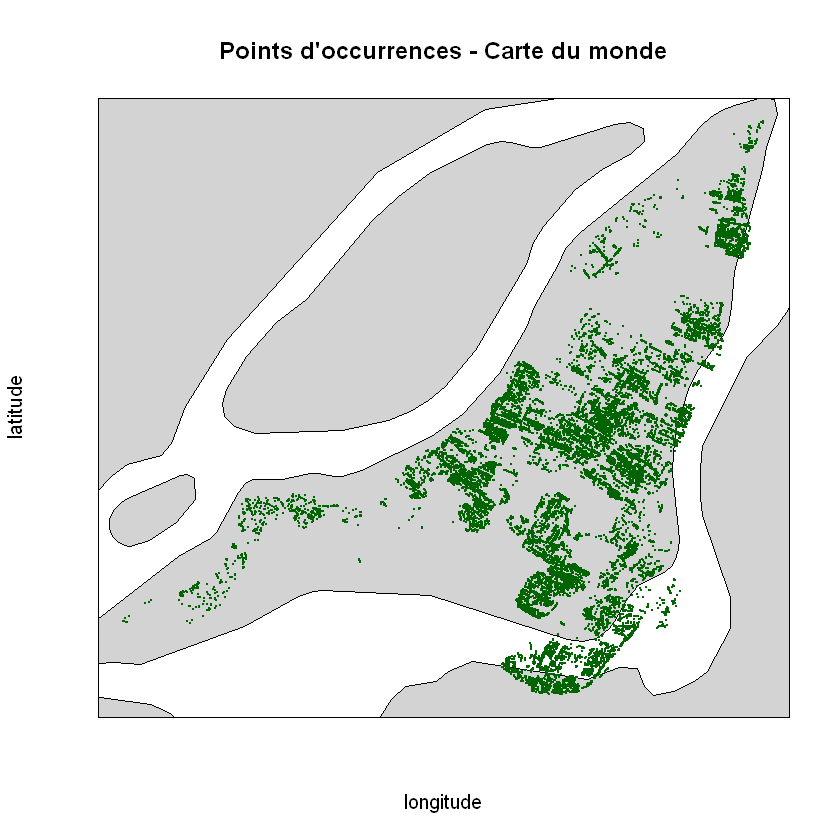

In [44]:
# Afficher les points sur la carte du monde
plot_species_data_on_map(species_data, plot_label="Points d'occurrences - Carte du monde")

Parfait, on voit maintenant que le points sont tous centrés autour de la ville de Montreal.

Mais ça dépasse. C'est clairement un problème de la carte du monde vu que l'on a vu que les points ne pouvaient pas dépasser les bordures de Montreal. Pour cette raison (entre autres), nous allons utiliser la carte des limites administratives de Montreal, qui est plus précise :

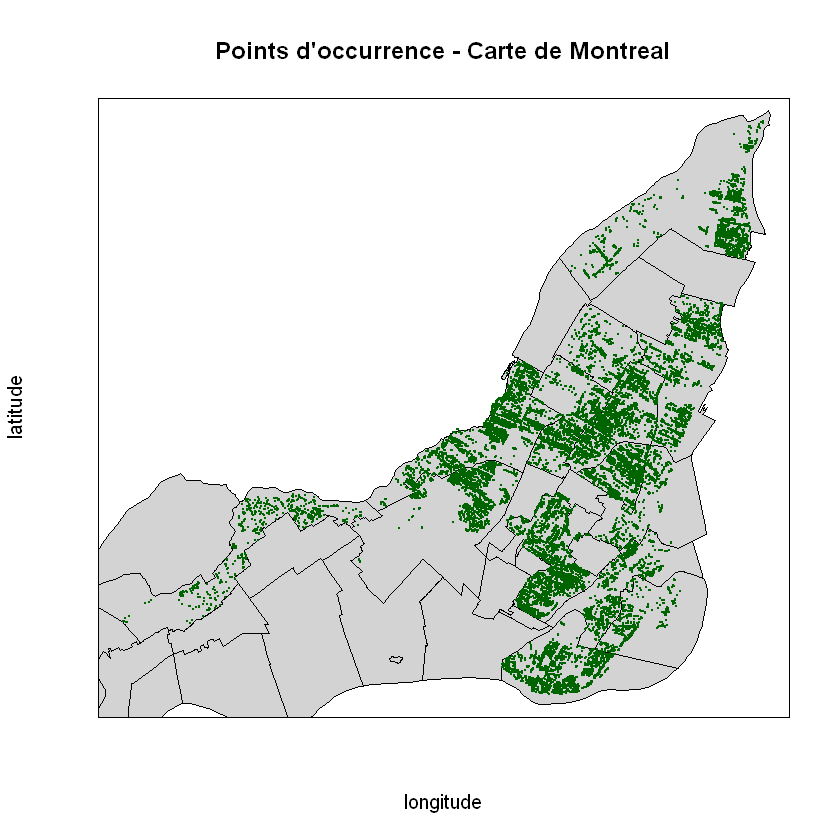

In [45]:
# Afficher les points sur la carte de Montreal
plot_species_data_on_map(species_data, background_map=montreal_map, plot_label="Points d'occurrence - Carte de Montreal")

### 2.2 - Gestion de biais d'echantillonage 

Le biais d'échantillonage peut être un problème dans l'analyse de données, et il est souvent pris en considération dans la distribution d'espèces. Il n'est cependant pas nécessaire dans cette étape car on fera naturelement du sous-echantillonnage plus tard dans le processus. 

Pour référence, voici comment on pourait sous échantilloner nos données d'occurrence (en prenant x=1 point d'occurrence par cellule) 

In [46]:
# Créer une grille (raster)
r_layer <- raster(ext=montreal_boundaries, res=0.00833333333333342)

# Echantilloner les points 
sampled_points = SpatialPoints(gridSample(species_data, r_layer, n=1))
species_data <- SpatialPointsDataFrame(data = data.frame(Present = rep(1, length(sampled_points))), coords=sampled_points)
 
# Afficher à nouveau les points d'occurrence
plot_species_data_on_map(species_data, background_map=montreal_map, 
#                          plot_label="Points d'occurrence - Carte de Montreal")

### 2.3 - Génération des données d'absence
Comme dit plus tôt, les données que l'on utilise sont des données de présence seulement, nous devons alors générer des données d'absence.

Ici nous allons utiliser une technique très simple, nous allons prendre des données dans toutes les cellules où du raster (même résolution que le raster climatique) où les points de présence n'y figurent pas. Pour cela on utilise la bibliothèque **dismo** et sa fonction **randomPoints** :

**Note : Une autre technique a été utilisée au préalable : cette de l'exclusion géographique. Le principe est de prendre des points d'absence à des points situés autour des points de présence à un rayon prédéterminé (voir ces deux ressources : https://www.sciencedirect.com/science/article/pii/S2215016119302596?via%3Dihub et https://www.molecularecologist.com/2013/04/23/species-distribution-models-in-r/).**

**Cependant elle n'a pas donné de bons résultats en termes de ratio entre l'exactitude au hasard et l'exactitude du modèle. J'ai donc décidé de changer de méthode de génération**

In [47]:
# Definir une valeur de 'seed' pour que les résultats soient les mêmes à chaque tentative
set.seed(12)

# Créer les cercles et y echantionner des points aléatoires
# circles_list <- circles(species_data, d=10000, lonlat=TRUE)
# circles_list@polygons <- spTransform(circles_list@polygons, crs(montreal_map))

# Génerer les points d'absence
# absence_data <- spsample(circles_list@polygons, length(species_data), type='random', iter=100)

r_layer <- raster(ext=montreal_boundaries, res=0.00833333333333342)
raster_mask = raster::rasterize(montreal_map, r_layer, res=res(r_layer))
absence_data = SpatialPoints(randomPoints( mask=raster_mask, n=length(species_data), p=species_data, tryf=100, lonlatCorrection=TRUE))

Warning message in randomPoints(mask = raster_mask, n = length(species_data), p = species_data, :
"changed n to ncell of the mask (extent)"Warning message in randomPoints(mask = raster_mask, n = length(species_data), p = species_data, :
"generated random points = 0.228327228327228 times requested number"

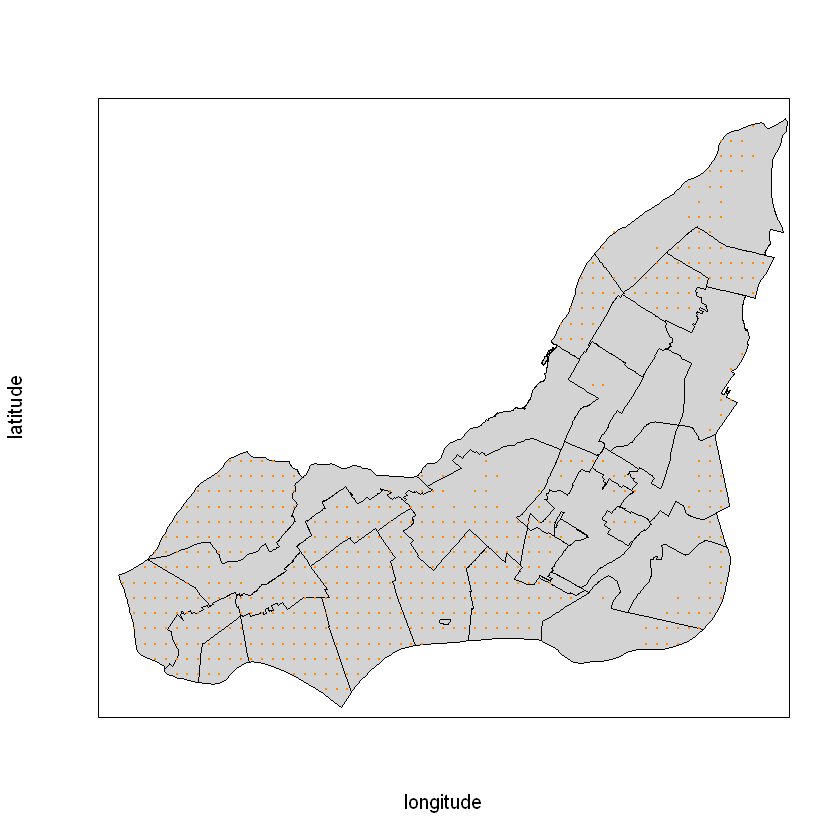

In [48]:
# Afficher les points d'absences sur la carte
plot_species_data_on_map(species_data=absence_data, background_map=montreal_map, col="dark orange")

Parfait, les points d'absence sont maintenant recentrés.

Maintenant, on combine les deux datasets ensemble pour obtenir nos données d'occurrences complètes :

In [50]:
# Transformer les données d'absence en SpatialPointsDataFrame (avec l'attribut Présent à 0)
absence_data <- SpatialPointsDataFrame(data = data.frame(Present = rep(0, length(absence_data))), coords=absence_data)

# Combiner les données d'absence et de présence
crs(absence_data) <- crs(species_data)
species_data <- rbind(species_data, absence_data)

### 2.3 - Données climatiques :

Pour les données climatiques, nous allons utiliser les données de **WORDLCIM** (https://www.worldclim.org/data/worldclim21.html (consulté le 19/04/2021) qui est une base de données climatiques couvrant le monde entier. Voici la liste des variables biologiques disponibles : 

- BIO1 - Température moyenne annuelle
- BIO2 - Moyenne de l'amplitude diurne (Moyenne des (max temp - min temp) mensuels)
- BIO3 - Isothermie (BIO2/BIO7) (×100)
- BIO4 - Saisonnalité de la température (écart-type ×100)
- BIO5 - Température maximale du mois le plus chaud
- BIO6 - Température minimale du mois le plus froid
- BIO7 - Plage annuelle de température (BIO5-BIO6)
- BIO8 - Température moyenne du trimestre le plus humide
- BIO9 - Température moyenne du trimestre le plus sec
- BIO10 - Température moyenne du trimestre le plus chaud
- BIO11 - Température moyenne du trimestre le plus froid
- BIO12 - Précipitations annuelles
- BIO13 - Précipitations du mois le plus humide
- BIO14 - Précipitations du mois le plus sec
- BIO15 - Saisonnalité des précipitations (coefficient de variation)
- BIO16 - Précipitations du trimestre le plus humide
- BIO17 - Précipitations du trimestre le plus sec
- BIO18 - Précipitations du trimestre le plus chaud
- BIO19 - Précipitations du trimestre le plus froid

(La précision utilisée ici est la plus fine, à savoir **30 degrés secondes, soit environ 1 kilomètre carré**.)

Nous allons maintenant extraire les valeurs de ces variables environnementales autour de chaque point de présence / absence de notre jeu de données, et pour illustrer ce processus, voici les étapes à suivre pour la variable **BIO_1** :

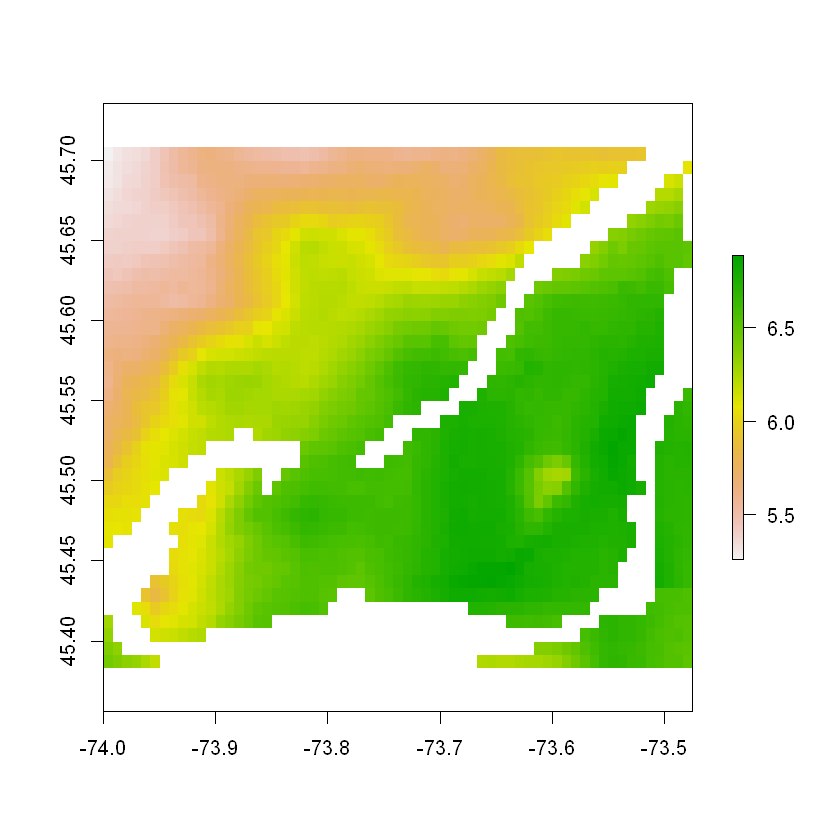

In [51]:
# Lire le fichier raster 
worldclim_path <- "data/worldclim_cropped"
climate_raster <- raster(file.path(worldclim_path, "wc2.1_30s_bio_1.tif"))

# Afficher le raster layer 
plot(climate_raster)

Les parties blanches que l'on peut remarquer sur la carte sont en fait des valeurs manquantes. Ce serait un problème de les laisser tels quels car certains points de présence / absence pourraient y figurer. Une stratégie pour remplacer ces valeurs manquantes est de d'utiliser la valeur moyenne des voisins les plus proches.

Pour faire ça, nous utiliserons la fonction **"focal"** pour faire déplacer une "fenêtre" (matrice) de taille fixe (ici paramétrée à 5x5) sur l'image raster et appliquer une fonction qui fera la moyenne des élements dans la fenêtre. Voici le code et le résultat obtenu :

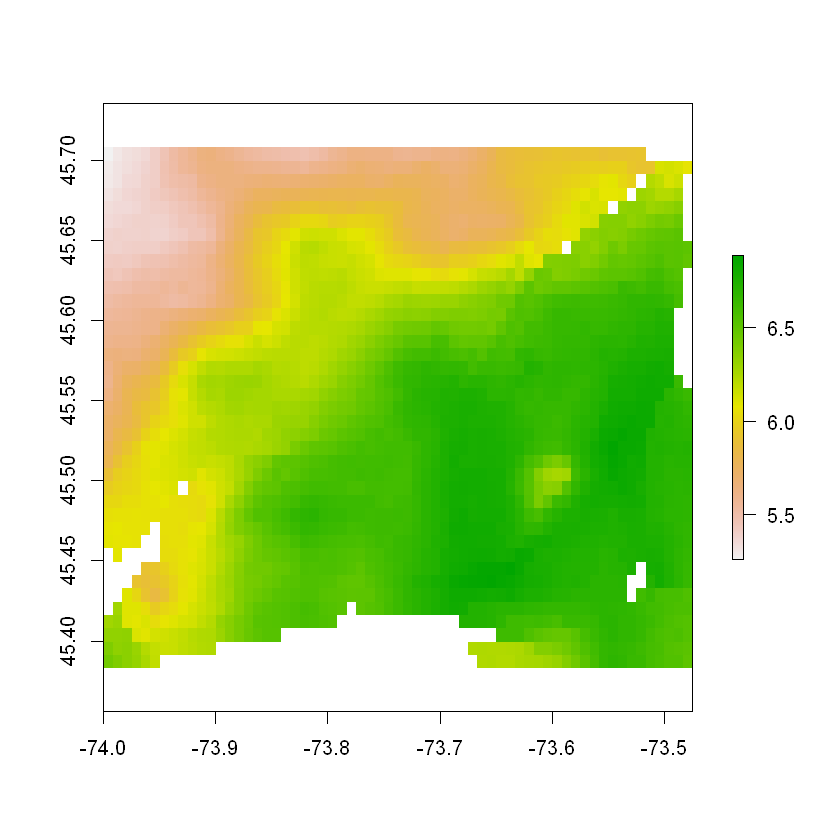

In [52]:
# La fonction qui retourne la moyenne des élements adjacents à chaque cellule
fill.na <- function(x, i=5) {return(mean(x, na.rm=TRUE))}  

# On spécifie à la fonction de ne prendre que les cellules dont les valeurs sont manquantes
climate_raster_averaged <- focal(climate_raster, w = matrix(1,3,3), fun = fill.na, NAonly=TRUE)

# Afficher le raster layer à nouveau
plot(climate_raster_averaged)

Parfait, nous pouvons maintenant finir le processus en faisant correspondre les points de présence avec les valeurs de la variable BIO_1 en utilisant la fonction **extract** du package raster.

In [53]:
# Dataframe d'affichage (pour ne pas changer notre dataset original)
species_data_dummy <- species_data 

# Extraire la variable climatique à chaque point d'occurrence
climate_variable <- raster::extract(climate_raster_averaged, species_data, method="bilinear")
    
# Ajouter la nouvelle feature dans le dataset
species_data_dummy@data["bio_1"] <- climate_variable

# Afficher le dataset lié 
head(species_data_dummy@data)

Present,bio_1
1,6.745425
1,6.727494
1,6.726983
1,6.726245
1,6.679311
1,6.679496


Tout semble en ordre, maintenant il ne reste qu'à répéter ce processus pour toutes les variables environnementales : 

In [54]:
# Lister les fichiers shapefile du climat de Montreal
filenames <- list.files(worldclim_path, pattern="*.tif", full.names=TRUE)

# Dataset complet 
species_data_final <- species_data

# Pour chaque fichier...
for(filename in filenames){
    # Charger le fichier en mémoire
    climate_raster <- raster(filename)
    
    # Enlever les valeurs manquantes
    climate_raster <- focal(climate_raster, w = matrix(1,5,5), fun = fill.na, NAonly=TRUE)
    
    # Stocker le nom de la variable (ex : bio_1)
    variable_name <- strsplit(filename, '_')[[1]]
    variable_name <- strsplit(variable_name[length(variable_name)], '.tif')
    variable_name <- paste('bio_', variable_name, sep="")
    
    # Extraire la variable climatique pour chaque point d'occurrence
    climate_variable <- raster::extract(climate_raster, species_data_final, col=variable_name, method="simple")
    
    # Ajouter la nouvelle feature dans le dataset
    species_data_final@data[variable_name] <- climate_variable
}

In [55]:
# Afficher le dataset complet 
head(species_data_final@data)

Present,bio_1,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9
1,6.750000,20.45000,-8.200000,987.0000,95.0,61.00000,12.84703,278.0000,202.0,270.0,218,9.866667,23.38073,1159.920,27.40,-14.80000,42.20000,19.38333,-6.933333
1,6.745833,20.45000,-8.216666,1001.0000,96.0,62.00000,12.39807,281.0000,207.0,274.0,220,9.891666,23.38456,1160.820,27.40,-14.90000,42.30000,19.40000,-6.966667
1,6.745833,20.45000,-8.216666,1001.0000,96.0,62.00000,12.39807,281.0000,207.0,274.0,220,9.891666,23.38456,1160.820,27.40,-14.90000,42.30000,19.40000,-6.966667
1,6.745833,20.45000,-8.216666,1001.0000,96.0,62.00000,12.39807,281.0000,207.0,274.0,220,9.891666,23.38456,1160.820,27.40,-14.90000,42.30000,19.40000,-6.966667
1,6.670833,20.34889,-8.267778,992.7333,95.2,61.13333,12.34116,277.8667,205.8,271.4,218,9.809444,23.30723,1158.956,27.22,-14.86667,42.08667,19.29778,-7.033333
1,6.670833,20.34889,-8.267778,992.7333,95.2,61.13333,12.34116,277.8667,205.8,271.4,218,9.809444,23.30723,1158.956,27.22,-14.86667,42.08667,19.29778,-7.033333


In [56]:
# Statistiques sur le dataset 
summary(species_data_final@data)

    Present           bio_1           bio_10          bio_11      
 Min.   :0.0000   Min.   :5.850   Min.   :19.17   Min.   :-8.960  
 1st Qu.:1.0000   1st Qu.:6.646   1st Qu.:20.28   1st Qu.:-8.317  
 Median :1.0000   Median :6.700   Median :20.37   Median :-8.217  
 Mean   :0.9833   Mean   :6.679   Mean   :20.33   Mean   :-8.190  
 3rd Qu.:1.0000   3rd Qu.:6.754   3rd Qu.:20.43   3rd Qu.:-8.110  
 Max.   :1.0000   Max.   :6.875   Max.   :20.57   Max.   :-7.533  
                  NA's   :65      NA's   :65      NA's   :65      
     bio_12         bio_13           bio_14          bio_15     
 Min.   : 948   Min.   : 91.00   Min.   :57.00   Min.   :11.40  
 1st Qu.: 995   1st Qu.: 95.00   1st Qu.:61.00   1st Qu.:12.68  
 Median :1007   Median : 97.00   Median :62.00   Median :12.91  
 Mean   :1006   Mean   : 97.11   Mean   :61.54   Mean   :12.94  
 3rd Qu.:1017   3rd Qu.: 99.00   3rd Qu.:62.00   3rd Qu.:13.21  
 Max.   :1064   Max.   :102.00   Max.   :65.00   Max.   :15.31  
 NA's   :

In [57]:
# Enlever les valeurs manquantes
length_before_na_omit <- count(species_data_final@data)$n
species_data_final = species_data_final[apply(species_data_final@data, FUN=function(x){!any(is.na(x))}, MARGIN=1), ]
length_after_na_omit <- count(species_data_final@data)$n
print(paste('Nombre de valeurs manquantes enlevées :', length_before_na_omit - length_after_na_omit))

# Identifier et enlever les variables qui ont 0 de variance
zero_variance_variables <- which(apply(species_data_final@data, 2, var) == 0)
num_zero_var_variables <- length(zero_variance_variables)
print(paste('Nombre de variables avec zéro variance enlevées :', num_zero_var_variables))
if (num_zero_var_variables > 0){
    print(paste('Attribut supprimés', colnames(species_data_final@data[as.numeric(zero_variance_variables)])))
    species_data_final@data <- species_data_final@data[ -as.numeric(zero_variance_variables)]
}

[1] "Nombre de valeurs manquantes enlevées : 65"
[1] "Nombre de variables avec zéro variance enlevées : 0"


Les attributs corréllés entre eux n'apportent pas d'information supplémentaires. Pour les faire ressortir nous pouvons utiliser une matrice de correlation. 

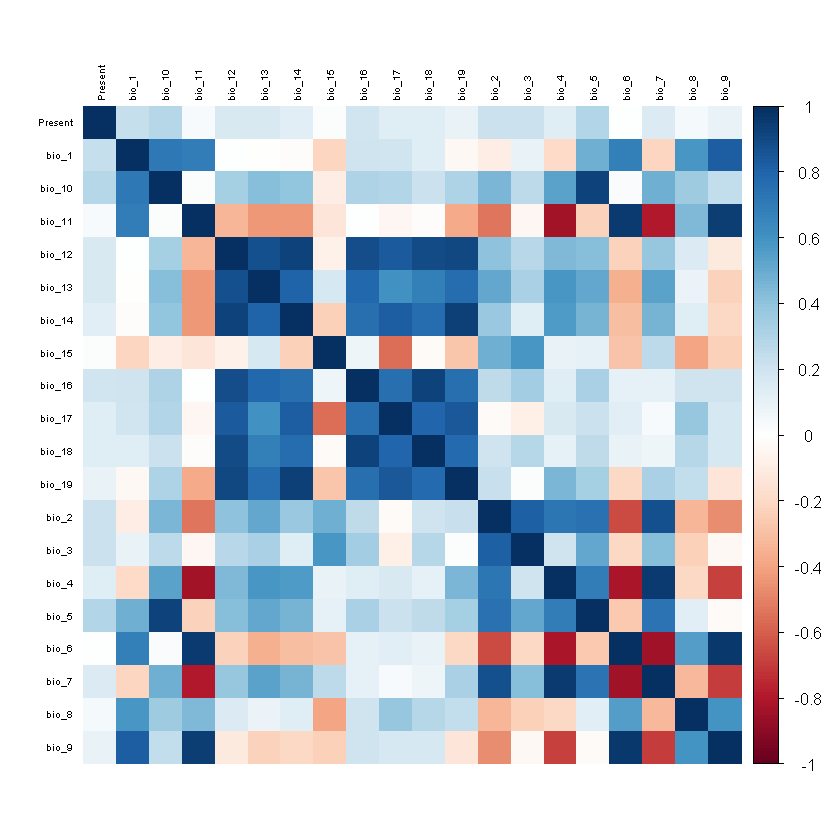

In [58]:
# Afficher la matrice de corrélation
cor_matrix <- cor(species_data_final@data)
corrplot(cor_matrix, method="color", tl.cex=.5, tl.col="black")

Pour éliminer les variables corrélés, nous utilisons généralement un seuil de **coefficient de correlation de Pearson**, au delà duquel une des deux variables corrélés dans la matrice est éliminée. Pour choisir ce seuil, faisons d'abord des statistiques simples montrant le nombre d'attributs supprimés en prenant en considération des seuils différents : 

In [59]:
# Eliminer le triangle supérieur de la matrice de correlation (car elle est symetrique)
cor_matrix[upper.tri(cor_matrix)] <- 0

# Fixer les valeurs dans la diagonale car les variables avec elles-mêmes ont un coefficient de 1
diag(cor_matrix) <- 0
                                                                     
# Faire des statistiques sur la corrélation des attributs
thresholds <- c(0.7, 0.8, 0.9, 0.99)
for (threshold in thresholds) {
    # Créer un dataset avec les attributs corréllés supprimés
    len_before_cleaning <- length(species_data_final@data)
    cleaned_dataset <- species_data_final@data[, !apply(cor_matrix, 2, function(x) any(abs(x) > threshold))]
    len_after_cleaning <- length(cleaned_dataset)
    
    # Afficher le nombre d'attributs supprimés dans ce nouveau dataset
    print(paste("Coefficient de Pearson (valeur absolue) : ", threshold, 
                " - Nombre d'attributs supprimés :", 
                len_before_cleaning - len_after_cleaning, "/", len_before_cleaning, sep=""))
}

[1] "Coefficient de Pearson (valeur absolue) : 0.7 - Nombre d'attributs supprimés :13/20"
[1] "Coefficient de Pearson (valeur absolue) : 0.8 - Nombre d'attributs supprimés :11/20"
[1] "Coefficient de Pearson (valeur absolue) : 0.9 - Nombre d'attributs supprimés :7/20"
[1] "Coefficient de Pearson (valeur absolue) : 0.99 - Nombre d'attributs supprimés :0/20"


Nous continuerons l'entrainement avec un seuil de coefficient de **0.9**.

In [60]:
species_data_final@data <- species_data_final@data[, !apply(cor_matrix, 2, function(x) any(abs(x) > 0.9))]

Nous allons maintenant vérifier si nous avons beaucoup de redondance dans nos enregistrements, pour ce faire, il suffit de faire ressortir les enregistrements dupliqués : 

In [61]:
# Compter le nombre d'enregistrements uniques dans le dataset
length_sp_data <- count(species_data_final@data)
print(paste("Nombre d'enregistrements uniques en incluant les classes :", count(species_data_final@data %>% distinct())$n, 
            "/", length_sp_data))

# Compter le nombre d'enregistrements sans la valeur cible 
print(paste("Nombre d'enregistrements uniques sans les classes :",
      count(species_data_final@data[2:length(species_data_final@data)] %>% distinct())$n, 
           "/", length_sp_data))

# Compter le nombre d'enregistrements par classes
print("==== Nombre d'enregistrements uniques par classe ====")
print(paste("Present = 1 :", count(species_data_final@data[species_data_final@data$Present == 1, ] %>% distinct())$n))
print(paste("Present = 0 :", count(species_data_final@data[species_data_final@data$Present == 0, ] %>% distinct())$n))

[1] "Nombre d'enregistrements uniques en incluant les classes : 1026 / 33543"
[1] "Nombre d'enregistrements uniques sans les classes : 991 / 33543"
[1] "==== Nombre d'enregistrements uniques par classe ===="
[1] "Present = 1 : 477"
[1] "Present = 0 : 549"


Nous avons beaucoup d'enregistrements dupliqués dans le dataset, c'est normal, car cela dépend de la précision de la carte des données climatiques. 

Nous allons enlever les données dupliqués, ce qui va massivement réduire le nombre d'informations superflues et accélerer l'entrainement. Cela sert aussi de sous-echantillonage, ce qui limite l'impact du biais d'echantillonage.

## 3. Entrainement des modèles
Dans ce projet, il sera question d'utiliser un algorithme de Machine Learning, à savoir le **Random Forest**.

### 3.1 - Séparation des données
La séparation des données de test se fera à l'aide de la technique dite de la **Block Cross Validation**.

La block cross validation est une technique de séparation des données qui consiste à prendre en considération la position des données dans l'espace (ou le temps).

Par exemple, une stratégie de block cross validation consiste à séparer l'espace en blocs de même taille à la manière d'une grille, chaque bloc sera alors numéroté de 1 jusqu'à k (le nombre de *folds*), puis les blocs ayant le même numéro seront regroupé dans un *fold*. Le but de cette stratégie est de prendre nos données à partir d'endroits relativement eloignés, comme l'illustre cette figure : 

<img src="https://besjournals.onlinelibrary.wiley.com/cms/asset/58e88b81-cd83-44b0-b6ed-f4bafd1c9f45/mee313107-fig-0002-m.png
          "/>

Ces techniques de validation croisée sont implémentés dans le package **blockCV** du langage R. 

Warning message in rasterNet(speciesData, resolution = theRange, xbin = cols, ybin = rows, :
 Progress [===================================================] 100% in 18st is assumed to have an un-projected reference system"


The best folds was in iteration 19:
  train_0 train_1 test_0 test_1
1     438     369    111    108
2     452     378     97     99
3     418     387    131     90
4     460     380     89     97
5     428     394    121     83


[1] "SpatialBlock"

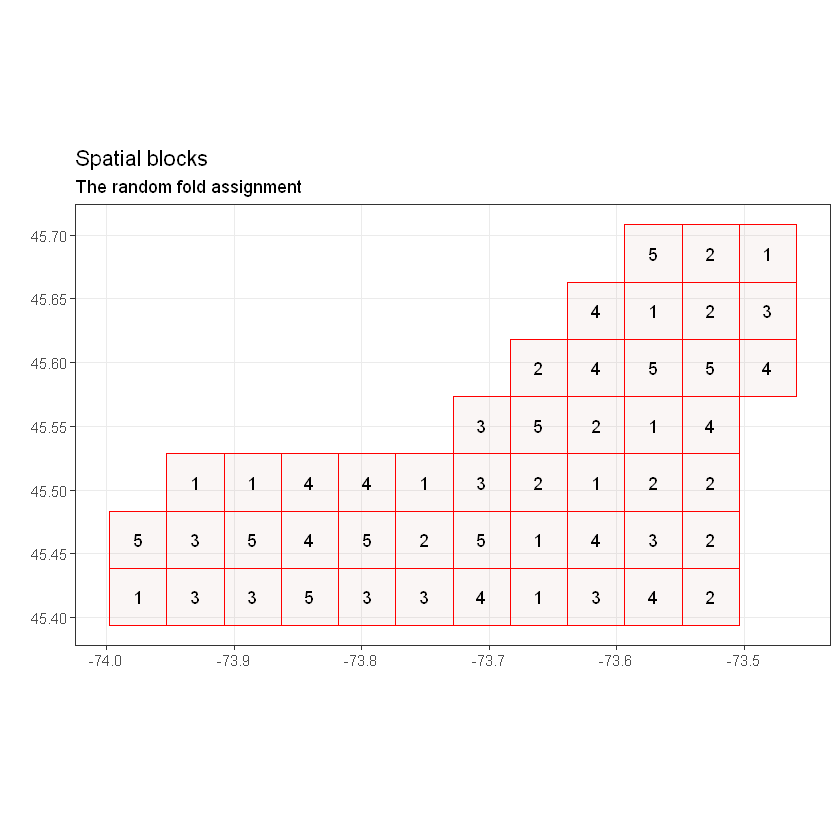

In [63]:
# Définir le CRS du dataset (pour éviter une erreur de BlockCV)
crs(climate_raster) <- NA
crs(species_data_final_trimmed) <- NA

# Stratégie de block spatiaux 
folds <- spatialBlock(speciesData = species_data_final_trimmed, # Données d'occurrence
                   species = "Present", # La colonne cible (la classe)
                   theRange = 5000, # Taille des blocks (en m)
                   k = 5, # Nombre de folds
                   # rasterLayer = climate_raster, # a raster for background (optional)
                   selection = "random", # Selection aléatoires de blocs 
                   iteration = 100, # Nombre d'itérations avant de trouver les blocs optimaux (bonne distribution des données)
                   biomod2Format = FALSE)

folds

### 3.2 - Entrainement du modèle

Maintenant la séparation faite, nous pouvons entrainer notre modèle : le Random Forest. 

Pour ce faire, nous allons entrainer un modèle sur chaque fold de notre cross validation, puis afficher les résultats et les moyennes des métriques de chaque modèle. Les métriques utilisés seront **l'accuracy**, **le coefficient de Kappa**, **l'aire sous la courbe ROC (AUROC)** et enfin **le No Information Rate** :

mtry = 3  OOB error = 14.13% 
Searching left ...
mtry = 2 	OOB error = 13.88% 
0.01754386 1e-06 
mtry = 1 	OOB error = 13.88% 
0 1e-06 
Searching right ...
mtry = 6 	OOB error = 13.51% 
0.02678571 1e-06 
mtry = 12 	OOB error = 13.75% 
-0.01834862 1e-06 
mtry = 3  OOB error = 14.82% 
Searching left ...
mtry = 2 	OOB error = 14.34% 
0.03252033 1e-06 
mtry = 1 	OOB error = 15.3% 
-0.06722689 1e-06 
Searching right ...
mtry = 6 	OOB error = 14.7% 
-0.02521008 1e-06 


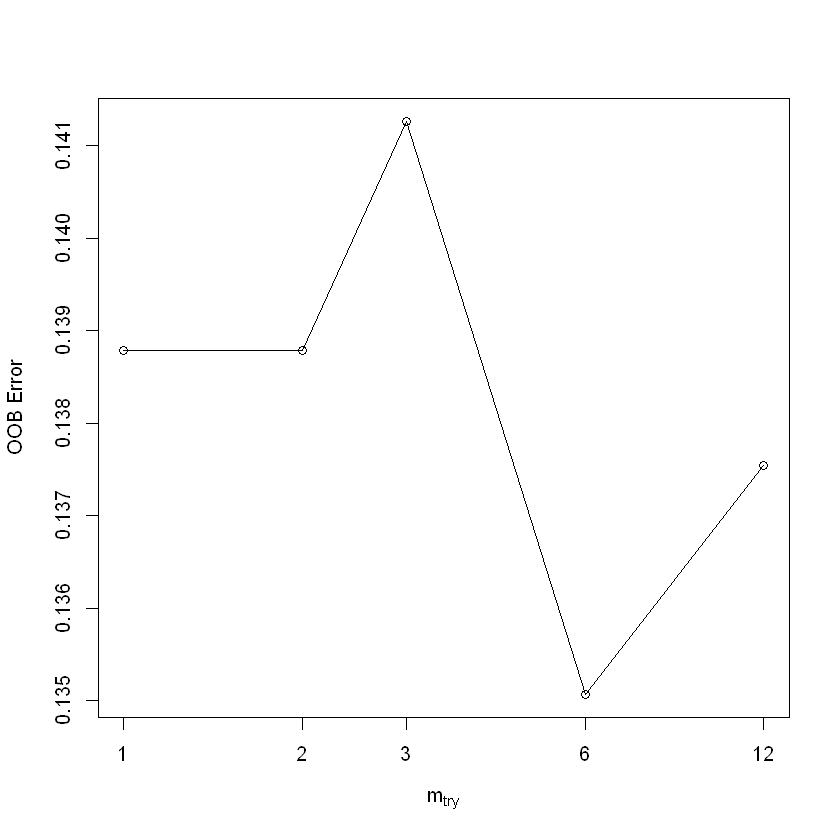

mtry = 3  OOB error = 18.26% 
Searching left ...
mtry = 2 	OOB error = 18.01% 
0.01360544 1e-06 
mtry = 1 	OOB error = 18.63% 
-0.03448276 1e-06 
Searching right ...
mtry = 6 	OOB error = 17.64% 
0.02068966 1e-06 
mtry = 12 	OOB error = 19.13% 
-0.08450704 1e-06 


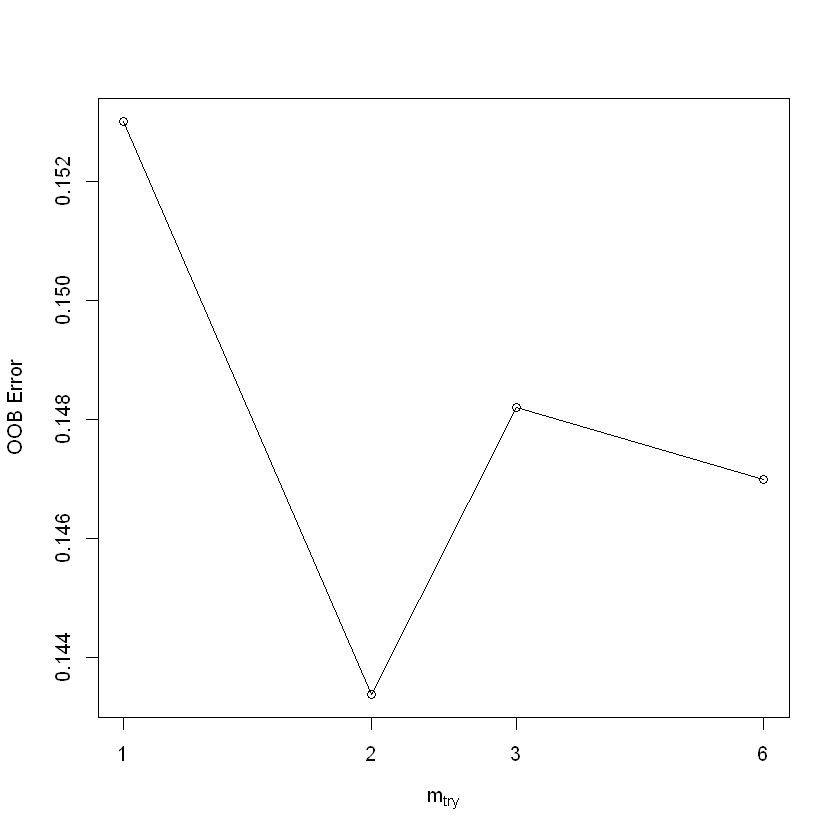

mtry = 3  OOB error = 15.12% 
Searching left ...
mtry = 2 	OOB error = 15.36% 
-0.01574803 1e-06 
Searching right ...
mtry = 6 	OOB error = 15.12% 
0 1e-06 


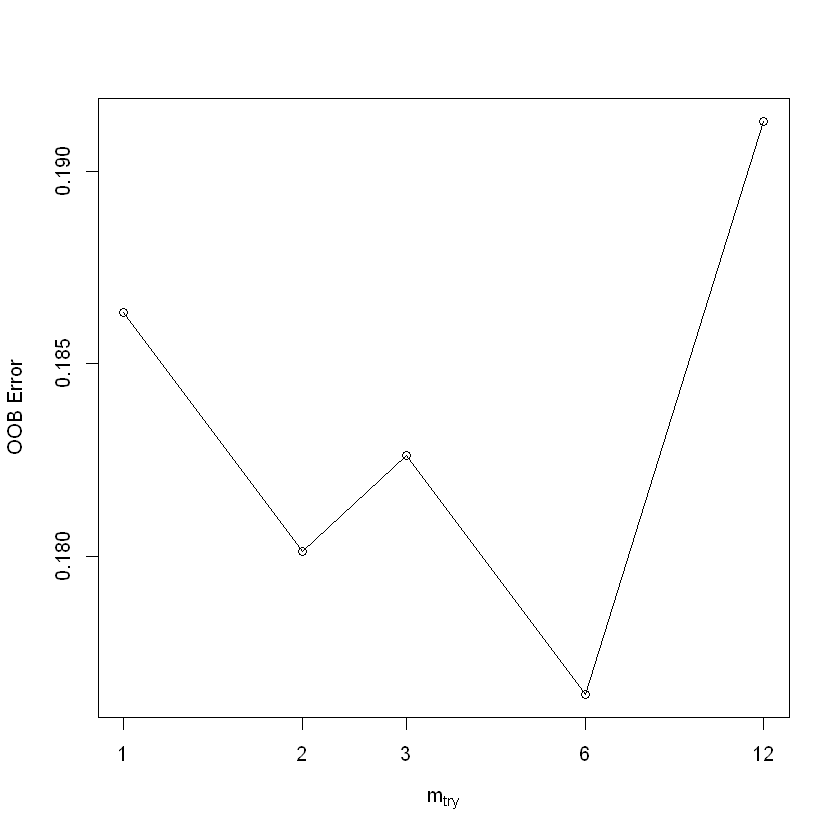

mtry = 3  OOB error = 16.91% 
Searching left ...
mtry = 2 	OOB error = 17.03% 
-0.007194245 1e-06 
Searching right ...
mtry = 6 	OOB error = 17.64% 
-0.04316547 1e-06 


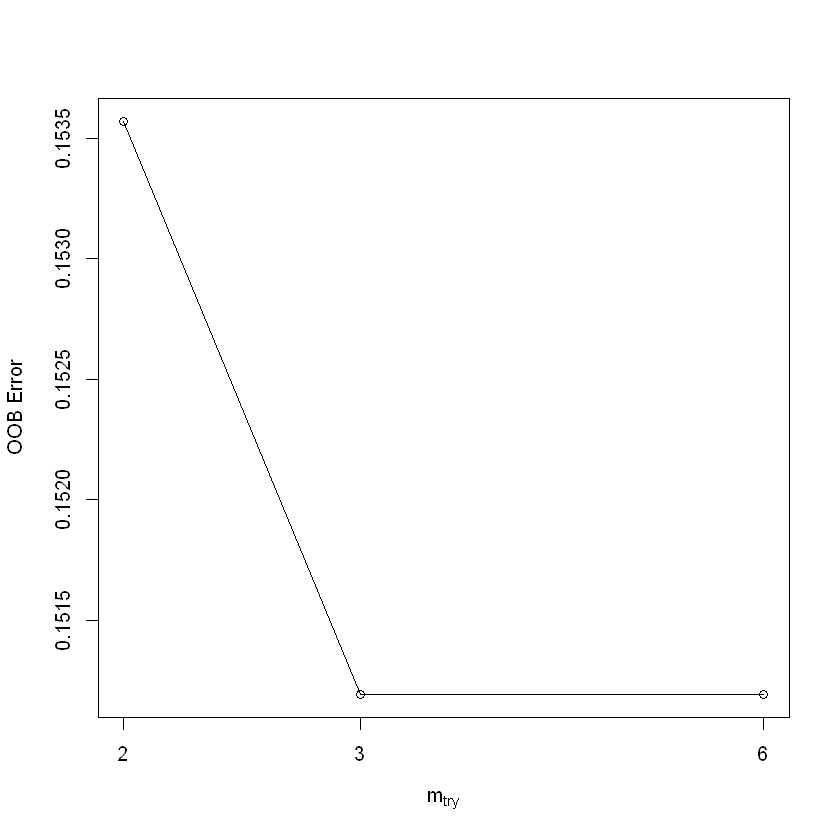

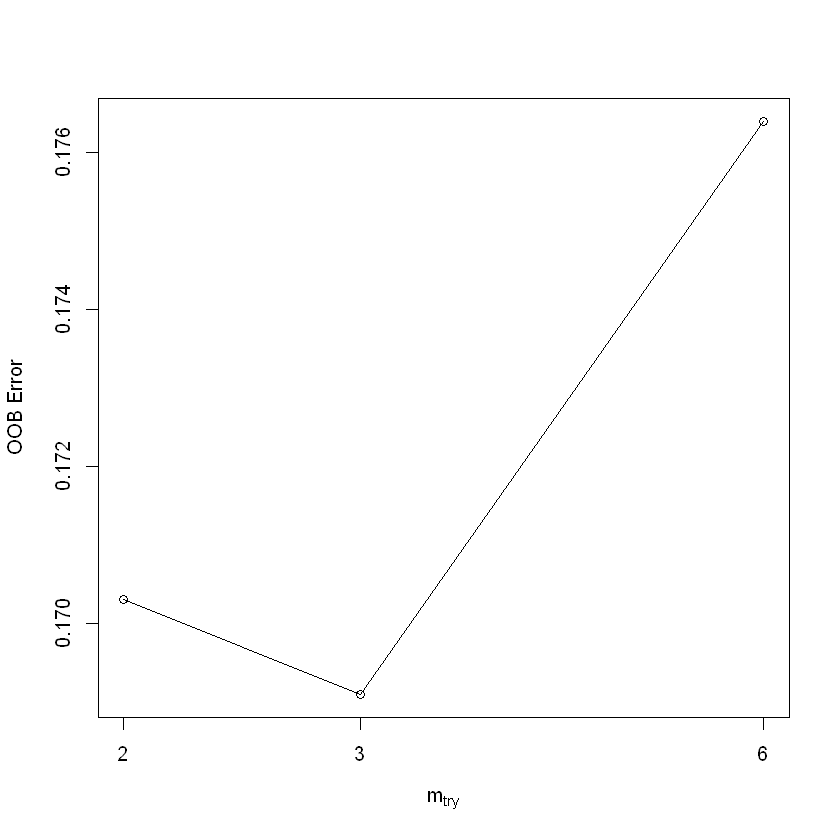

In [64]:
# Métriques 
# --- Entrainement ----
train_accuracy <- numeric(length(folds$folds))
train_kappa <- numeric(length(folds$folds))
train_auc <- numeric(length(folds$folds))
train_f1_measure <- numeric(length(folds$folds))
train_no_information_rate <- numeric(length(folds$folds))

# --- Test ----
accuracy <- numeric(length(folds$folds))
kappa <- numeric(length(folds$folds))
auc <- numeric(length(folds$folds))
f1_measure <- numeric(length(folds$folds))
no_information_rate <- numeric(length(folds$folds))

# Modèles et predictions
rf <- vector("list", (length(folds$folds)))
# predictions <- vector("list", (length(folds$folds)))

# Pour chaque fold...
for (i in 1:length(folds$folds)){
    fold <- folds$folds[[i]]
    
    # Extraire les données d'entrainement
    xy_train <- species_data_final_trimmed[fold[1][[1]], ]@data
    y_train <- xy_train$Present
    x_train <- xy_train[2:length(colnames(xy_train))]
    
    # Extraire les données de test
    xy_test <- species_data_final_trimmed[fold[2][[1]], ]@data
    
    # Entrainer le modèle Random Forest (paramètres par défault)
    # sdm_rf <- randomForest(x_train, as.factor(y_train))
    sdm_rf <- tuneRF(x_train, as.factor(y_train), stepFactor=2, plot=FALSE, trace=FALSE,
                     improve=1e-6, ntree=501, doBest=TRUE) 
    rf[[i]] <- sdm_rf
    
    # ===== METRIQUES ======
    # Nous utilisons la fonction confusionMatrix de Caret 
    # pour obtenir les metriques suivantes : accuracy, kappa et no_information_rate
    
    # ------ ENTRAINEMENT ------
    prediction <- predict(sdm_rf, xy_train)
    
    # Accuracy / Kappa / NIR / F-Measure
    cm <- confusionMatrix(as.factor(xy_train$Present), as.factor(prediction))
    overall <- cm[3][[1]]
    train_accuracy[i] <- overall[1]
    train_kappa[i] <- overall[2]
    train_no_information_rate[i] <- overall[5]
    
    byClass <- cm[4][[1]]
    train_f1_measure[i] <- byClass[7]
    
    # AUC
    rf_p_train <- predict(sdm_rf, type="prob", newdata=xy_train)[,2]
    rf_pr_train <- prediction(rf_p_train, as.factor(xy_train$Present))
    train_auc[i] <- performance(rf_pr_train, measure = "auc")@y.values[[1]] 
    
    # ----- TEST ------
    prediction <- predict(sdm_rf, xy_test)
    
    cm <- confusionMatrix(as.factor(xy_test$Present), as.factor(prediction))
    overall <- cm[3][[1]]
    accuracy[i] <- overall[1]
    kappa[i] <- overall[2]
    no_information_rate[i] <- overall[5]
    
    byClass <- cm[4][[1]]
    f1_measure[i] <- byClass[7]
    
    # Calculer l'AUC
    rf_p_train <- predict(sdm_rf, type="prob", newdata=xy_test)[,2]
    rf_pr_train <- prediction(rf_p_train, as.factor(xy_test$Present))
    auc[i] <- performance(rf_pr_train, measure = "auc")@y.values[[1]]
}

Maintenant que les modèles ont été entrainés, il est temps de faire d'afficher les résultats. 

In [67]:
# Data frame contenant les statistiques de nos modèles
model_stats = data.frame(
    Train_Accuracy=train_accuracy, 
    Train_Kappa=train_kappa, 
    Train_NIR=train_no_information_rate,
    Train_Auc=train_auc, 
    Train_F1_Measure=train_f1_measure,
    Accuracy=accuracy, 
    Kappa=kappa, 
    No_Information_Rate=no_information_rate,
    Auc=auc,
    F1_Measure=f1_measure
)

cat('\n===== STATISTIQUES DES MODELES =====\n')
head(model_stats)

# Afficher les moyennes des metriques
cat('\n===== MOYENNES =====\n')

cat('\n--- Entrainement ----\n\n')
print(paste('Moyenne accuracy (entrainement): ', as.character(format(round(mean(model_stats$Train_Accuracy), 4), nsmall = 4)), 
            "%", sep=""))
print(paste('Moyenne kappa (entrainement) : ', as.character(format(round(mean(model_stats$Train_Kappa), 4), nsmall = 4)), 
            "%", sep=""))
print(paste('Moyenne AUC (entrainement): ', as.character(format(round(mean(model_stats$Train_Auc), 4), nsmall = 4)), 
            "%", sep=""))
print(paste('Moyenne NIR (entrainement): ', as.character(format(round(mean(model_stats$Train_NIR), 4), 
                                                                nsmall = 4)), "%", sep=""))

cat('\n--- Test ----\n\n')
print(paste('Moyenne accuracy (test): ', as.character(format(round(mean(model_stats$Accuracy), 4), nsmall = 4)), "%", sep=""))
print(paste('Moyenne kappa (test) : ', as.character(format(round(mean(model_stats$Kappa), 4), nsmall = 4)), "%", sep=""))
print(paste('Moyenne AUC (test): ', as.character(format(round(mean(model_stats$Auc), 4), nsmall = 4)), "%", sep=""))
print(paste('Moyenne NIR (test): ', as.character(format(round(mean(model_stats$No_Information_Rate), 4), nsmall = 4)), 
            "%", sep=""))

# Statistiques complètes
cat("\n\n===== STATISTIQUES COMPLETES =====\n")
summary(model_stats)


===== STATISTIQUES DES MODELES =====


Train_Accuracy,Train_Kappa,Train_NIR,Train_Auc,Train_F1_Measure,Accuracy,Kappa,No_Information_Rate,Auc,F1_Measure
0.9702602,0.9400568,0.5452292,0.9982181,0.9726651,0.7716895,0.5431790,0.5159817,0.8054721,0.7767857
0.9662651,0.9316044,0.5759036,0.9976354,0.9698925,0.6938776,0.3856441,0.6683673,0.7895970,0.6296296
0.9627329,0.9251543,0.5540373,0.9972182,0.9652778,0.8280543,0.6256241,0.7194570,0.9385920,0.8689655
0.9726190,0.9444700,0.5726190,0.9983953,0.9755579,0.6827957,0.3641210,0.5268817,0.7467856,0.6666667
0.9622871,0.9243763,0.5316302,0.9971506,0.9641618,0.7892157,0.5641026,0.5882353,0.8383949,0.8215768



===== MOYENNES =====

--- Entrainement ----

[1] "Moyenne accuracy (entrainement): 0.9668%"
[1] "Moyenne kappa (entrainement) : 0.9331%"
[1] "Moyenne AUC (entrainement): 0.9977%"
[1] "Moyenne NIR (entrainement): 0.5559%"

--- Test ----

[1] "Moyenne accuracy (test): 0.7531%"
[1] "Moyenne kappa (test) : 0.4965%"
[1] "Moyenne AUC (test): 0.8238%"
[1] "Moyenne NIR (test): 0.6038%"


===== STATISTIQUES COMPLETES =====


 Train_Accuracy    Train_Kappa       Train_NIR        Train_Auc     
 Min.   :0.9623   Min.   :0.9244   Min.   :0.5316   Min.   :0.9972  
 1st Qu.:0.9627   1st Qu.:0.9252   1st Qu.:0.5452   1st Qu.:0.9972  
 Median :0.9663   Median :0.9316   Median :0.5540   Median :0.9976  
 Mean   :0.9668   Mean   :0.9331   Mean   :0.5559   Mean   :0.9977  
 3rd Qu.:0.9703   3rd Qu.:0.9401   3rd Qu.:0.5726   3rd Qu.:0.9982  
 Max.   :0.9726   Max.   :0.9445   Max.   :0.5759   Max.   :0.9984  
 Train_F1_Measure    Accuracy          Kappa        No_Information_Rate
 Min.   :0.9642   Min.   :0.6828   Min.   :0.3641   Min.   :0.5160     
 1st Qu.:0.9653   1st Qu.:0.6939   1st Qu.:0.3856   1st Qu.:0.5269     
 Median :0.9699   Median :0.7717   Median :0.5432   Median :0.5882     
 Mean   :0.9695   Mean   :0.7531   Mean   :0.4965   Mean   :0.6038     
 3rd Qu.:0.9727   3rd Qu.:0.7892   3rd Qu.:0.5641   3rd Qu.:0.6684     
 Max.   :0.9756   Max.   :0.8281   Max.   :0.6256   Max.   :0.7195     
      Auc    

### 3.3 - Interprétation des résultats

Le taux d'exactitude au dessus de **75%** est relativement satisfaisant, mais il faut surtout se concentrer sur les autres métriques. 

L'AUC, une métrique indépendante du seuil de classification, montre un résultat satisfaisant. Il dépasse de **7%** notre taux d'exactitude, ce qui peut laisser penser que le seuil de classification (par défaut à 0.5) pourrait être mieux choisi pour obtenir des meilleures performances.

Le coefficient de **0.5** Kappa montre que l'impact de l'imbalance dans les données est réduit, l'éxactitude est donc bien supérieure au hasard.

Pour confirmer cela, le no information rate représente la référence, à savoir le taux d'exactitude si on devinait au hasard, et on remarque que bien qu'il est au dessus de la moyenne (c'est normal, car les deux classes ne sont pas parfaitement distribuées), l'exactitude de notre modèle est plus grande.

### 4 - Conclusion

Le processus de création d'un modèle de distribution d'espèce peut s'avérer compliqué si l'on prend pas en considération certains éléments comme l'autocorrélation spatiale ou l'imbalance des données. Cependant, les étapes décrites dans ce notebook ont permi d'atteindre un résultat satisfaisant, et ce même sur la petite région de la ville de Montreal (qui dispose de moins de données climatiques). 

Ce processus peut être amélioré :
- En entrainant plusieurs modèles à la fois et utiliser leurs prédictions (principe de l'outil BIOMOD)
- En approfondissant la recherche d'hyperparamètres associés à chaque modèle
- En gérant d'une meilleure façon la génération de pseudo-absences
